In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
import logging
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error
import datetime

In [2]:
os.chdir(r'/content/drive/MyDrive/AppliedAI/self_case_study_1/ashrae_energy_prediction')

# Load Data:

In [ ]:
#https://towardsdatascience.com/how-to-reduce-the-size-of-a-pandas-dataframe-in-python-7ed6e4269f88
def compress(df, verbose=True):
    ## downcasting loop
    start_mem = np.round(df.memory_usage().sum() / 1024**2, 3)
    for column in df:
        if df[column].dtype == 'float64':
            df[column]=pd.to_numeric(df[column], downcast='float')
        if (df[column].dtype== 'int64') or (df[column].dtype== 'int32'):
            df[column]=pd.to_numeric(df[column], downcast='integer')
    end_mem = np.round(df.memory_usage().sum() / 1024**2, 3)
    if verbose:
        print(f"Memory usage reduced to {end_mem:8} MB: Memory reduction by {(start_mem-end_mem)*100/start_mem}%")
    return df

def read_building_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'building_metadata.csv')))
def read_train_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'train.csv'), parse_dates=['timestamp']))
def read_test_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'test.csv'), parse_dates=['timestamp']))
def read_weather_train_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'weather_train.csv'), parse_dates=['timestamp']))
def read_weather_test_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'weather_test.csv'), parse_dates=['timestamp']))
def read_all_data(input_data_path):
    return read_building_data(input_data_path), read_train_data(input_data_path),\
           read_test_data(input_data_path), read_weather_train_data(input_data_path),\
           read_weather_test_data(input_data_path)

In [ ]:
building_metadata_df, train_df, test_df, weather_train_df, weather_test_df = read_all_data('data/input_data')

Memory usage reduced to    0.032 MB: Memory reduction by 51.515151515151516%
Memory usage reduced to  289.194 MB: Memory reduction by 53.12498480420522%
Memory usage reduced to  596.489 MB: Memory reduction by 53.12500491155275%
Memory usage reduced to    4.932 MB: Memory reduction by 48.614294644717646%
Memory usage reduced to    9.783 MB: Memory reduction by 48.61060040972843%


In [ ]:
#compress and dump file for future use
pickle.dump(building_metadata_df, open('data/input_data/building_metadata_df.pkl', 'wb'))
pickle.dump(train_df, open('data/input_data/train_df.pkl', 'wb'))
pickle.dump(test_df, open('data/input_data/test_df.pkl', 'wb'))
pickle.dump(test_df[test_df.timestamp.dt.year==2017], open('data/input_data/test_df_2017.pkl', 'wb'))
pickle.dump(test_df[test_df.timestamp.dt.year==2018], open('data/input_data/test_df_2018.pkl', 'wb'))
pickle.dump(weather_train_df, open('data/input_data/weather_train_df.pkl', 'wb'))
pickle.dump(weather_test_df, open('data/input_data/weather_test_df.pkl', 'wb'))

# Preprocessing and Feature Engineering

## building data

In [ ]:
def preprocess_building_data(building_metadata_df, train=True):
    df = building_metadata_df.copy()
    #floor_count
    df['floor_count'].fillna(0, inplace=True)
    df['floor_count'] = (df['floor_count'] + 1).astype(np.int8) #we treat ground floor as 1 floor_count
    #square_feet
    df['log_sq_ft'] = np.log(df['square_feet']).astype(np.float16)
    #primary_use
    df['primary_use'] = df.primary_use.str.lower().replace(re.compile(r'(/| )'), "_")
    if train:
        primary_use_label = sorted(df.primary_use.unique())
        primary_use_label_map = {label:i for i, label in enumerate(primary_use_label, start=1)}
        primary_use_label_map['UNK'] = 0
        pickle.dump(primary_use_label_map, open('data/processed_data/primary_use_label_map.pkl', 'wb'))
    else:
        primary_use_label_map = pickle.load(open('data/processed_data/primary_use_label_map.pkl', 'rb'))
    df['primary_use'] = df.primary_use.replace(primary_use_label_map).astype(np.int8)
    #year_built
    bins = np.arange(0, 201, 25)
    labels = np.arange(1, bins.shape[0])
    df['year_built'] = df['year_built'] - 1900 + 1
    df['year_built_label'] = pd.cut(df['year_built'], bins = bins , labels = labels,
                             include_lowest = True, ordered=False).astype(np.float16).fillna(0).astype(np.int8)
    df['year_built'] = df['year_built'].fillna(0).astype(np.int32)
    df = compress(df)
    assert df.isna().sum().sum() == 0
    return df

In [ ]:
def building_fe_pipeline(data):
    df = data.copy()
    df = compress(df.assign(floor_sq_feet = df['floor_count']*df['log_sq_ft']))
    return df

## weather data

In [ ]:
def weather_preprocessing_pipleine(df, year=[2016], apply_offset=True, offsets=None):
    #return preprocessed weather data
    logging.debug("Weather data preprocessing started...")
    print("Weather data preprocessing started...")
    try:
        logging.debug("Checking file type of parameter year...")
        assert isinstance(year, list), "Please provide year in list format"
        if apply_offset:
            logging.debug("Checking file type of parameter offsets...")
            assert isinstance(offsets, list) if offsets is not None else True, "offsets should be a list"
            logging.debug("Verifying length of offsets with number of unique site_id...")
            assert df.site_id.unique().shape[0] == len(offsets) if offsets is not None else True,\
                "length of offsets should match unique site_id"
    except AssertionError as e:
        logging.error(e)
        print(e)
        return df
    logging.debug("Input data verified. Vreating a copy for input data for preprocessing...")
    print("Input data verified. Vreating a copy for input data for preprocessing...")
    df = df.copy()
    logging.debug("Checking for apply_offset condition...")
    if apply_offset:
        logging.debug("apply_offset = True")
        logging.debug("checking for input offsets...")
        if offsets is None:
            logging.debug("offsets not provided. Will use default offsets list")
            print("offsets not provided. Will use default offsets list")
            offsets = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]
        #apply offset based on site_id
        logging.debug("Applying offset based on site_id")
        print("Applying offset based on site_id")
        for site_id, offset in enumerate(offsets):
            logging.debug(f"site_id == {site_id}")
            row_condition = df['site_id'] == site_id
            df.loc[row_condition, 'timestamp'] = df.timestamp + pd.to_timedelta(offset, unit='h')
        #filter values other than year provided
        logging.debug("Filtering input data by year...")
        print("Filtering input data by year...")
        print("Before filter...")
        print(df.shape)
        filter_by_year = (df.timestamp.dt.year.isin(year))
        df = df.loc[filter_by_year, :]
        logging.debug(f"After filtering input shape: {df.shape}")
        print("After filter...")
        print(df.shape)
    #func1 apply linear interpolation for missing timestamp
    logging.debug(f"Applying func1 on input data...")
    print("Before func1...")
    print(df.isna().sum())
    weather_train_df_p = df.groupby('site_id').apply(lambda group: func1(group))
    #func1 post processing
    print("After func1...")
    print(weather_train_df_p.isna().sum())
    logging.debug(f"Applying func1 post processing on input data...")
    weather_train_df_p = weather_train_df_p.reset_index(drop=True)
    print("After func1 post processing...")
    print(weather_train_df_p.isna().sum())
    #compute median value of preprocessed weather data
    logging.debug(f"Computing median value of preprocessed data at given timestamp...")
    impute_weather_data = weather_train_df_p.groupby(['timestamp']).median()
    #there are still some columns remaining for which we do not have any value to impute
    #for such columns we impute hourly median data
    logging.debug("Applying func2: Imputing remaining features by median values at given timestamp...")
    print("Applying func2: Imputing remaining features by median values at given timestamp...")
    weather_train_df_p = weather_train_df_p.groupby('site_id').apply(lambda group: func2(group, impute_weather_data))
    print("After Applying func2...")
    print(weather_train_df_p.isna().sum())
    logging.debug(f"Weather data preprocessing completed...")
    return weather_train_df_p

def func2(data, impute_weather_data):
    df = data.copy()
    logging.debug(f"Site Id: {df['site_id'].iloc[0]}")
    site_id = df['site_id'].iloc[0]
    logging.debug(df.isna().sum())
    cols = sorted(df.isna().sum().index[(df.isna().sum() > 0)])
    logging.debug(f"columns with missing values: {cols}")
    if len(cols)>0:
        df.loc[:, cols] = impute_weather_data[cols].values
        try:
            assert df.isna().sum().sum()==0,\
             f"Some values are still missing in site {site_id}"
        except AssertionError as e:
            logging.error(e)
    else:
        logging.debug("Nan value not found return as it is")
    logging.debug("=" * 80)
    return df

def func1(data):
    df = data.copy()
    #fill missing timestamp with nan
    logging.debug(f"Site Id: {df['site_id'].iloc[0]}")
    site_id = df['site_id'].iloc[0]
    min_year = df.timestamp.dt.year.min()
    max_year = df.timestamp.dt.year.max()
    logging.debug(f"Min year: {min_year}")
    logging.debug(f"Max year: {max_year}")
    delta=1
    df = df.set_index('timestamp')
    new_timestamp = pd.date_range(f'{min_year}-01-01', f'{max_year+delta}-01-01', freq='H', closed='left', name='timestamp')
    df = df.reindex(new_timestamp).reset_index()
    #interpolate missing value
    cols = sorted(set(df.columns) - {'timestamp', 'site_id'})
    logging.debug("Before interpolation...")
    logging.debug(df.isna().sum())
    df[cols] = df[cols].interpolate(method='linear', limit_direction='both', axis=0)
    df.loc[:, 'site_id'] = site_id
    logging.debug("=" * 40)
    logging.debug("After interpolation...")
    logging.debug(df.isna().sum())
    logging.debug("=" * 80)
    return df

def _add_past_feature_(data, window=18):
    df = data.copy()
    col = ["air_temperature", "cloud_coverage","dew_temperature", "precip_depth_1_hr"]
    df_rolled = df.groupby("site_id")[["air_temperature", "cloud_coverage",
                                       "dew_temperature", "precip_depth_1_hr"]]\
                                       .rolling(window=window, min_periods=0)

    df_max = df_rolled.max().reset_index()
    df_min = df_rolled.min().reset_index()
    df_mean = df_rolled.mean().reset_index()
    df_median = df_rolled.median().reset_index()
    df_std = df_rolled.std().reset_index()

    print(df_max.isna().sum())
    print(df_min.isna().sum())
    print(df_mean.isna().sum())
    print(df_median.isna().sum())
    print(df_std.isna().sum())

    for column in col:
        df[f"{column}_max_past_{window}"] = df_max[column]
        df[f"{column}_min_past_{window}"] = df_min[column]
        df[f"{column}_mean_past_{window}"] = df_mean[column]
        df[f"{column}_median_past_{window}"] = df_median[column]
        df[f"{column}_std_past_{window}"] = df_std[column]
    # df.drop(columns=col, inplace=True)

    print(df.isna().sum())
    print('Filling nan values...')
    df.fillna(method='bfill', inplace=True)

    for column in col:
        df[f"{column}_max_past_{window}"] = df[f"{column}_max_past_{window}"].astype(np.float16)
        df[f"{column}_min_past_{window}"] = df[f"{column}_min_past_{window}"].astype(np.float16)
        df[f"{column}_mean_past_{window}"] = df[f"{column}_mean_past_{window}"].astype(np.float16)
        df[f"{column}_median_past_{window}"] = df[f"{column}_median_past_{window}"].astype(np.float16)
        df[f"{column}_std_past_{window}"] = df[f"{column}_std_past_{window}"].astype(np.float16)

    return df

def get_sin_hour(hour):
    return np.sin((hour+13)*2*np.pi/24)

def get_sin_month(month):
    return np.sin((month+0.5)*2*np.pi/24)

def get_wind_direction_label(direction_in_deg):
    return np.sin(2*np.pi*(direction_in_deg+90)/360)

def weather_fe_pipeline(data):
    df = data.copy()
    df = _add_past_feature_(data=df, window=18)

    #add basic time data like month, dayofweek, hour
    df = df.assign(month=df.timestamp.dt.month,
                   dayofweek=df.timestamp.dt.dayofweek,
                   hour=df.timestamp.dt.hour,
                   quarter=df.timestamp.dt.quarter)\
                   .astype({'month':np.int8,
                            'dayofweek':np.int8,
                            'hour':np.int8,
                            'quarter':np.int8})

    df = df.assign(sin_hour = get_sin_hour(df['hour']),
                   sin_month = get_sin_month(df['month']),
                   sin_wind_direction = get_wind_direction_label(df['wind_direction']))\
                   .astype({'sin_hour':np.float16,
                            'sin_month':np.float16,
                            'sin_wind_direction':np.float16})

    df['wind_direction'] = df['wind_direction'].replace({360:0}) // 45

    df = df.astype({'air_temperature':np.float16,
                    'cloud_coverage':np.float16,
                    'dew_temperature':np.float16,
                    'precip_depth_1_hr':np.float16,
                    'sea_level_pressure':np.float16,
                    'wind_speed':np.float16,
                    'wind_direction':np.int8})
    return df

## meter_data

In [ ]:
def preprocess_train_data(train_df, building_metadata_df):
    p_train_df = train_df.copy()
    p_train_df = p_train_df.merge(building_metadata_df[['building_id', 'site_id']], on='building_id', how='left')
    assert p_train_df.shape[0] == train_df.shape[0]
    p_train_df = p_train_df.pivot(columns=['meter', 'site_id', 'building_id'], index='timestamp', values='meter_reading')
    df_roll_sum = p_train_df.rolling(window=48, min_periods=0).sum()
    df_roll_sum = df_roll_sum.unstack().rename(index='meter_reading_sum').reset_index()
    p_train_df = p_train_df.unstack().rename(index='meter_reading').reset_index()
    df_roll_sum.drop(columns='site_id', inplace=True)
    p_train_df = p_train_df.merge(df_roll_sum, on=['meter', 'building_id', 'timestamp'], how='left')
    del df_roll_sum
    #remove 48 hour streak of electrical reading
    condition = (p_train_df['meter'] == 0) & (p_train_df['meter_reading_sum'] == 0)
    p_train_df = p_train_df[~condition]
    #remove 0 hotwater/steam reading in core winter season for window of 48 hours
    condition = ((p_train_df['meter'] == 2)|(p_train_df['meter'] == 3)) &\
                (p_train_df['meter_reading_sum'] == 0) & \
                (p_train_df['timestamp'].dt.month.isin([1,2,3,4,12]))
    p_train_df = p_train_df[~condition]
    #remove 0 coldwater reading in core summer season for window of 48 hours
    condition = (p_train_df['meter'] == 1) &\
                (p_train_df['meter_reading_sum'] == 0) & \
                (p_train_df['timestamp'].dt.month.isin([4,5,6,7,8,9,10]))
    p_train_df = p_train_df[~condition]
    p_train_df.drop(columns='meter_reading_sum', inplace=True)
    #remove site 0 meter 0 reading for first 140 days
    condition = (p_train_df.meter==0) & (p_train_df.site_id==0) & (p_train_df.timestamp.dt.dayofyear<141)
    p_train_df = p_train_df[~condition]
    p_train_df = compress(p_train_df)
    #drop nan
    p_train_df = p_train_df.dropna()
    #remove outliers
    condition = (p_train_df['building_id'] == 1099) & (p_train_df['meter'] == 2) & (p_train_df['meter_reading'] > 350000)
    p_train_df = p_train_df[~condition]

    #remove 0 electrical reading
    condition = (p_train_df.meter==0) & (p_train_df.meter_reading==0)
    p_train_df = p_train_df[~condition]

    #(0,904)
    condition = (p_train_df.meter==0) & (p_train_df.building_id==904) & ((p_train_df.meter_reading>750) | (p_train_df.meter_reading<350))
    p_train_df = p_train_df[~condition]

    #(0,954)
    condition = (p_train_df.meter==0) & (p_train_df.building_id==905) & ((p_train_df.meter_reading>2000) | (p_train_df.meter_reading<400))
    p_train_df = p_train_df[~condition]

    #(0,955)
    condition = (p_train_df.meter==0) & (p_train_df.building_id==955) & ((p_train_df.meter_reading>2000) | (p_train_df.meter_reading<500))
    p_train_df = p_train_df[~condition]

    #(0,993)
    condition = (p_train_df.meter==0) & (p_train_df.building_id==993) & (p_train_df.meter_reading>2000)
    p_train_df = p_train_df[~condition]

    #(1,778)
    condition = (p_train_df.meter==1) & (p_train_df.building_id==778)
    p_train_df = p_train_df[~condition]

    #(1,site_id=9)
    condition = (p_train_df.meter==1) & (p_train_df.site_id==9) & (p_train_df.meter_reading>1500)
    p_train_df = p_train_df[~condition]

    #create log_meter_reading
    p_train_df = p_train_df.assign(log_meter_reading=np.log1p(p_train_df['meter_reading']))

    #drop site_id
    p_train_df = p_train_df.drop(columns='site_id')
    return p_train_df

## Prepare Data

In [ ]:
def prepare_data(meter_data, building_data, weather_data):
    return meter_data.merge(building_data, on=['building_id'], how='left')\
                     .merge(weather_data, on=['site_id', 'timestamp'], how='left')

In [ ]:
#load raw compressed data
train_df = pickle.load(open('data/input_data/train_df.pkl', 'rb'))
test_df_2017 = pickle.load(open('data/input_data/test_df_2017.pkl', 'rb'))
test_df_2018 = pickle.load(open('data/input_data/test_df_2018.pkl', 'rb'))
weather_train_df = pickle.load(open('data/input_data/weather_train_df.pkl', 'rb'))
weather_test_df = pickle.load(open('data/input_data/weather_test_df.pkl', 'rb'))
building_metadata_df = pickle.load(open('data/input_data/building_metadata_df.pkl', 'rb'))

In [ ]:
p_weather_train_df = weather_preprocessing_pipleine(df=weather_train_df, year=[2016], apply_offset=True, offsets=None)
p_weather_test_df = weather_preprocessing_pipleine(df=weather_test_df, year=[2017,2018], apply_offset=True, offsets=None)
p_building_metadata_df = preprocess_building_data(building_metadata_df, train=True)
p_train_df = preprocess_train_data(train_df, building_metadata_df)

In [ ]:
pickle.dump(p_weather_train_df, open('data/processed_data/p_weather_train_df.pkl', 'wb'))
pickle.dump(p_weather_test_df, open('data/processed_data/p_weather_test_df.pkl', 'wb'))
pickle.dump(p_building_metadata_df, open('data/processed_data/p_building_metadata_df.pkl', 'wb'))
pickle.dump(p_train_df, open('data/processed_data/p_train_df.pkl', 'wb'))

In [ ]:
fe_weather_train_df = weather_fe_pipeline(data=p_weather_train_df)
fe_weather_test_df = weather_fe_pipeline(data=p_weather_test_df)
fe_building_metadata_df = building_fe_pipeline(data=p_building_metadata_df)

In [ ]:
pickle.dump(fe_weather_train_df, open('data/fe_data/fe_weather_train_df.pkl', 'wb'))
pickle.dump(fe_weather_test_df, open('data/fe_data/fe_weather_test_df.pkl', 'wb'))
pickle.dump(fe_building_metadata_df, open('data/fe_data/fe_building_metadata_df.pkl', 'wb'))

In [ ]:
base_path = 'data/final_data/'
final_data_2016_path = base_path + 'final_data_2016.pkl'
final_data_2017_path = base_path + 'final_data_2017.pkl'
final_data_2018_path = base_path + 'final_data_2018.pkl'

if True:
    p_train_df = pickle.load(open('data/processed_data/p_train_df.pkl', 'rb')) 
    test_df_2017 = pickle.load(open('data/input_data/test_df_2017.pkl', 'rb')) 
    test_df_2018 = pickle.load(open('data/input_data/test_df_2018.pkl', 'rb')) 
    fe_building_metadata_df = pickle.load(open('data/fe_data/fe_building_metadata_df.pkl', 'rb')) 
    fe_weather_train_df = pickle.load(open('data/fe_data/fe_weather_train_df.pkl', 'rb')) 
    fe_weather_test_df = pickle.load(open('data/fe_data/fe_weather_test_df.pkl', 'rb')) 
    
final_data_2016 = prepare_data(meter_data=p_train_df,
                               building_data=fe_building_metadata_df,
                               weather_data=fe_weather_train_df)

final_data_2017 = prepare_data(meter_data=test_df_2017,
                               building_data=fe_building_metadata_df,
                               weather_data=fe_weather_test_df)

final_data_2018 = prepare_data(meter_data=test_df_2018,
                               building_data=fe_building_metadata_df,
                               weather_data=fe_weather_test_df)

In [66]:
# pickle.dump(final_data_2016, open('data/final_data/final_data_2016.pkl', 'wb'))
# pickle.dump(final_data_2017, open('data/final_data/final_data_2017.pkl', 'wb'))
# pickle.dump(final_data_2018, open('data/final_data/final_data_2018.pkl', 'wb'))

# Experiment (Modeling)

In [3]:
final_data_2016 = pickle.load(open('data/final_data/final_data_2016.pkl', 'rb'))
# final_data_2017 = pickle.load(open('data/final_data/final_data_2017.pkl', 'rb'))
# final_data_2018 = pickle.load(open('data/final_data/final_data_2018.pkl', 'rb'))

In [7]:
final_data_2016[final_data_2016.meter==3].tail(10)

,meter,building_id,timestamp,meter_reading,log_meter_reading,site_id,primary_use,square_feet,year_built,floor_count,...,dayofweek,hour,quarter,sin_hour,sin_month,sin_wind_direction,quarter_mean,month_mean,dayofweek_mean,hour_mean
19067345,3,1028,2016-12-31 14:00:00,133.039993,4.898138,11,1,81390,0,1,...,5,14,4,0.707031,-0.130493,0.342041,80.020805,132.509735,116.186836,152.448364
19067346,3,1028,2016-12-31 15:00:00,136.110992,4.920791,11,1,81390,0,1,...,5,15,4,0.866211,-0.130493,0.342041,80.020805,132.509735,116.186836,158.528717
19067347,3,1028,2016-12-31 16:00:00,131.826996,4.889048,11,1,81390,0,1,...,5,16,4,0.965820,-0.130493,0.342041,80.020805,132.509735,116.186836,165.498016
19067348,3,1028,2016-12-31 17:00:00,134.737000,4.910719,11,1,81390,0,1,...,5,17,4,1.000000,-0.130493,0.500000,80.020805,132.509735,116.186836,168.939560
19067349,3,1028,2016-12-31 18:00:00,128.270996,4.861911,11,1,81390,0,1,...,5,18,4,0.965820,-0.130493,0.342041,80.020805,132.509735,116.186836,158.200226
19067350,3,1028,2016-12-31 19:00:00,133.281998,4.899942,11,1,81390,0,1,...,5,19,4,0.866211,-0.130493,0.342041,80.020805,132.509735,116.186836,161.060287
19067351,3,1028,2016-12-31 20:00:00,131.018997,4.882946,11,1,81390,0,1,...,5,20,4,0.707031,-0.130493,0.342041,80.020805,132.509735,116.186836,162.716003
19067352,3,1028,2016-12-31 21:00:00,122.935997,4.819765,11,1,81390,0,1,...,5,21,4,0.500000,-0.130493,0.342041,80.020805,132.509735,116.186836,139.860413
19067353,3,1028,2016-12-31 22:00:00,125.764999,4.842335,11,1,81390,0,1,...,5,22,4,0.258789,-0.130493,0.342041,80.020805,132.509735,116.186836,77.274963
19067354,3,1028,2016-12-31 23:00:00,121.401001,4.807302,11,1,81390,0,1,...,5,23,4,0.000000,-0.130493,0.342041,80.020805,132.509735,116.186836,93.278511


In [7]:
df = final_data_2016[['building_id', 'meter', 'quarter', 'month', 'dayofweek', 'hour', 'meter_reading']].copy()

In [ ]:
quarter_mean = df.groupby(['building_id', 'meter', 'quarter'])\
                 .agg(quarter_mean = ('meter_reading', 'mean')).reset_index()\
                 .astype({'building_id':np.int16, 'meter':np.int8, 'quarter':np.int8})
quarter_mean.dtypes, quarter_mean.isna().sum().sum()

month_mean = df.groupby(['building_id', 'meter', 'month'])\
                 .agg(month_mean = ('meter_reading', 'mean')).reset_index()\
                 .astype({'building_id':np.int16, 'meter':np.int8, 'month':np.int8})
month_mean.dtypes, month_mean.isna().sum().sum()

dayofweek_mean = df.groupby(['building_id', 'meter', 'month', 'dayofweek'])\
                 .agg(dayofweek_mean = ('meter_reading', 'mean')).reset_index()\
                 .astype({'building_id':np.int16, 'meter':np.int8, 'month':np.int8,
                          'dayofweek':np.int8})
dayofweek_mean.dtypes, dayofweek_mean.isna().sum().sum()

hour_mean = df.groupby(['building_id', 'meter', 'month', 'hour'])\
              .agg(hour_mean = ('meter_reading', 'mean')).reset_index()\
              .astype({'building_id':np.int16, 'meter':np.int8, 'month':np.int8,
                       'hour':np.int8})
hour_mean.dtypes, hour_mean.isna().sum().sum()

del df

In [ ]:
final_data_2016 = final_data_2016.merge(quarter_mean, 
                                        on=['building_id', 'meter', 'quarter'],
                                        how='left')

final_data_2016 = final_data_2016.merge(month_mean, 
                                        on=['building_id', 'meter', 'month'],
                                        how='left')

final_data_2016 = final_data_2016.merge(dayofweek_mean, 
                                        on=['building_id', 'meter', 'month', 'dayofweek'],
                                        how='left')

final_data_2016 = final_data_2016.merge(hour_mean, 
                                        on=['building_id', 'meter', 'month', 'hour'],
                                        how='left')

In [8]:
final_data_2016[['quarter_mean', 'month_mean', 'dayofweek_mean', 'hour_mean']] = np.log1p(final_data_2016[['quarter_mean', 'month_mean', 'dayofweek_mean', 'hour_mean']])

In [39]:
final_data_2017 = final_data_2017.merge(quarter_mean, 
                                        on=['building_id', 'meter', 'quarter'],
                                        how='left')

final_data_2017 = final_data_2017.merge(month_mean, 
                                        on=['building_id', 'meter', 'month'],
                                        how='left')

final_data_2017 = final_data_2017.merge(dayofweek_mean, 
                                        on=['building_id', 'meter', 'month', 'dayofweek'],
                                        how='left')

final_data_2017 = final_data_2017.merge(hour_mean, 
                                        on=['building_id', 'meter', 'month', 'hour'],
                                        how='left')

In [40]:
final_data_2017[['quarter_mean', 'month_mean', 'dayofweek_mean', 'hour_mean']].isna().sum()

quarter_mean      423144
month_mean        640704
dayofweek_mean    789168
hour_mean         671418
dtype: int64

In [43]:
final_data_2017[['quarter_mean', 'month_mean', 'dayofweek_mean', 'hour_mean']] = np.log1p(final_data_2017[['quarter_mean', 'month_mean', 'dayofweek_mean', 'hour_mean']])

In [49]:
final_data_2017[(final_data_2017.meter==3) & (final_data_2017.month_mean==0)]['month'].value_counts()

7     20088
8     18600
9     11520
6     10080
10     8928
5      7440
11     4320
2       672
Name: month, dtype: int64

In [50]:
final_data_2017.fillna(-1, inplace=True)

In [ ]:
final_data_2017[(final_data_2017.meter==0) & (final_data_2017.building_id==0)]

In [57]:
final_data_2018 = final_data_2018.merge(quarter_mean, 
                                        on=['building_id', 'meter', 'quarter'],
                                        how='left')

final_data_2018 = final_data_2018.merge(month_mean, 
                                        on=['building_id', 'meter', 'month'],
                                        how='left')

final_data_2018 = final_data_2018.merge(dayofweek_mean, 
                                        on=['building_id', 'meter', 'month', 'dayofweek'],
                                        how='left')

final_data_2018 = final_data_2018.merge(hour_mean, 
                                        on=['building_id', 'meter', 'month', 'hour'],
                                        how='left')

In [58]:
final_data_2018[['quarter_mean', 'month_mean', 'dayofweek_mean', 'hour_mean']] = np.log1p(final_data_2018[['quarter_mean', 'month_mean', 'dayofweek_mean', 'hour_mean']])

In [59]:
final_data_2018.fillna(-1, inplace=True)

In [60]:
final_data_2018[final_data_2018.quarter_mean==-1]['meter'].value_counts()

0    351312
1     34992
2     32520
3      4320
Name: meter, dtype: int64

In [61]:
df = final_data_2018[final_data_2018.meter==3]
df[df.quarter_mean==-1]['building_id'].unique()

array([279, 287], dtype=int16)

In [62]:
df = final_data_2018[final_data_2018.meter==2]
df[df.quarter_mean==-1]['building_id'].unique()

array([ 783,  954, 1072, 1250, 1327, 1361, 1394, 1402, 1405, 1409, 1412],
      dtype=int16)

In [64]:
df = final_data_2018[final_data_2018.meter==1]
df[df.quarter_mean==-1]['building_id'].unique()

array([  28,   98,  778,  954, 1018, 1022, 1130, 1160, 1413], dtype=int16)

In [65]:
df = final_data_2018[final_data_2018.meter==0]
df[df.quarter_mean==-1]['building_id'].unique()

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   17,   18,   19,   20,   21,   22,
         24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,
         35,   36,   37,   38,   39,   40,   41,   42,   43,   44,   45,
         46,   47,   48,   49,   50,   51,   52,   53,   54,   55,   56,
         57,   58,   59,   60,   61,   62,   63,   64,   65,   66,   67,
         68,   69,   70,   71,   72,   73,   74,   75,   76,   77,   78,
         79,   80,   81,   82,   83,   84,   85,   86,   87,   88,   89,
         90,   91,   92,   93,   94,   95,   96,   97,   98,   99,  100,
        101,  102,  103,  104,   16,   23,  403,  528,  555,  420,  487,
        567,  568,  591,  604,  607,  621,  647,  681,  802,  803,  815,
        857,  905,  954,  997,  886, 1005, 1006, 1024, 1011, 1113, 1169,
       1221, 1281, 1264, 1325, 1345, 1430], dtype=int16)

In [11]:
class experiment():
    def __init__(self, data, root_path='./project/results.csv'):
        self.data = data.copy()
        # self.models = dict()
        # self.results = dict()
        # self.features = dict()
        self.root_path = root_path
        if os.path.exists(root_path):
            self.results = pd.read_csv(root_path)
        else:
            self.results = pd.DataFrame(columns=['experiment_name', 'description', 'model',
                                                 'result', 'features','categorical_feature',
                                                 'train_data',
                                                 'val_data'])
        self.curr_model = None

    def prepare(self, name, feature, split_month=6, description='', n=500, building_sample=None):
        if (name == self.results.experiment_name).any():
            assert False, f"experiment {name} already exists please provide different name"

        data_train = self.data[self.data.timestamp.dt.month <= split_month]
        data_test = self.data[self.data.timestamp.dt.month > split_month]

        X_pre_train = data_train[feature + ['timestamp']]
        y_pre_train = data_train['log_meter_reading']

        X_pre_test = data_test[feature + ['timestamp']]
        y_pre_test = data_test['log_meter_reading']

        #sample 100 building for our first-cut solution
        if building_sample is None:
            building_sample = np.random.choice(1449, n, replace=False)
        else:
            try:
                assert isinstance(building_sample, list), "building sample should be a list"
            except AssertionError as e:
                print(e)
                return

        X_pre_train_sampled = X_pre_train.loc[X_pre_train.building_id.isin(building_sample)]
        y_pre_train_sampled = y_pre_train.loc[X_pre_train.building_id.isin(building_sample)]

        X_pre_test_sampled = X_pre_test.loc[X_pre_test.building_id.isin(building_sample)]
        y_pre_test_sampled = y_pre_test.loc[X_pre_test.building_id.isin(building_sample)]

        return (X_pre_train_sampled, y_pre_train_sampled, X_pre_test_sampled, y_pre_test_sampled)


    def run(self, name, feature, categorical_feature, month_list, split_month=6, description='', n=500, building_sample=None):
        X_pre_train_sampled, y_pre_train_sampled, X_pre_test_sampled, y_test = self.prepare(name, feature,
                                                                                            split_month,
                                                                                            description, n,
                                                                                            building_sample)
        X_test = X_pre_test_sampled.drop(columns='timestamp')
        if not os.path.exists('model'):
            os.makedirs('model')


        for month in month_list:
            param = {'num_leaves':70, 
                    'max_depth':7, 
                    'n_estimators':500,
                    'subsample ':0.8,
                    'subsample_freq':5,
                    'colsample_bytree':0.8,
                    'reg_alpha':0.1,
                    'reg_lambda':0.1}

            X_train = X_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month <= month].drop(columns='timestamp')
            X_train = X_train[feature]
            y_train = y_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month <= month]

            X_val = X_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month > month].drop(columns='timestamp')
            X_val = X_val[feature]
            y_val = y_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month > month]

            self.curr_model = LGBMRegressor(**param)
            self.curr_model.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse',
                                feature_name= feature,
                                categorical_feature= categorical_feature,
                                callbacks=[early_stopping(10)], verbose=101)
            
            y_hat_test = self.curr_model.predict(X_test[feature])
            result = mean_squared_error(y_test, y_hat_test)
            
            model_path = os.path.join('model', f"{name}-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.pkl")
            pickle.dump(self.curr_model, open(model_path,'wb'))

            my_dict = {'experiment_name':name,
                       'description':description,
                       'model':model_path,
                       'result':result,
                       'features':[feature],
                       'categorical_feature':[categorical_feature],
                       'train_data':split_month,
                       'val_data':month}
            self.results = pd.concat([self.results, pd.DataFrame(my_dict)], ignore_index=True)
        self.results.to_csv(self.root_path, index=False)

    def prepare_by_day(self, name, feature, split_day=15, description='', n=500, building_sample=None):
        if (name == self.results.experiment_name).any():
            assert False, f"experiment {name} already exists please provide different name"

        data_train = self.data[self.data.timestamp.dt.day <= split_day]
        data_test = self.data[self.data.timestamp.dt.day > split_day]

        # X_pre_train = data_train[feature]
        y_pre_train = data_train['log_meter_reading']

        # X_pre_test = data_test[feature]
        y_pre_test = data_test['log_meter_reading']

        #sample 100 building for our first-cut solution
        if building_sample is None:
            building_sample = np.random.choice(1449, n, replace=False)
        else:
            try:
                assert isinstance(building_sample, list), "building sample should be a list"
            except AssertionError as e:
                print(e)
                return

        X_pre_train_sampled = data_train.loc[data_train.building_id.isin(building_sample)][feature]
        y_pre_train_sampled = y_pre_train.loc[data_train.building_id.isin(building_sample)]

        X_pre_test_sampled = data_test.loc[data_test.building_id.isin(building_sample)][feature]
        y_pre_test_sampled = y_pre_test.loc[data_test.building_id.isin(building_sample)]

        return (X_pre_train_sampled, y_pre_train_sampled, X_pre_test_sampled, y_pre_test_sampled)

    def run_by_day(self, name, feature, categorical_feature, split_day=15, description='', n=500, building_sample=None):
        X_train, y_train, X_val, y_val = self.prepare_by_day(name, feature,
                                                             split_day,
                                                             description, n,
                                                             building_sample)
        X_train = X_train[feature]
        X_val = X_val[feature]

        param = {'num_leaves':70, 
                'max_depth':7, 
                'n_estimators':500,
                'subsample ':0.8,
                'subsample_freq':5,
                'colsample_bytree':0.8,
                'reg_alpha':0.1,
                'reg_lambda':0.1}
                    
        self.curr_model = LGBMRegressor(**param)
        self.curr_model.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse',
                            feature_name= feature,
                            categorical_feature= categorical_feature,
                            callbacks=[early_stopping(10)], verbose=101)
            
        model_path = os.path.join('model', f"{name}-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.pkl")
        pickle.dump(self.curr_model, open(model_path,'wb'))

        my_dict = {'experiment_name':name,
                    'description':description,
                    'model':model_path,
                    'result':'None',
                    'features':[feature],
                    'categorical_feature':[categorical_feature],
                    'train_data':split_day,
                    'val_data':'None'}
        self.results = pd.concat([self.results, pd.DataFrame(my_dict)], ignore_index=True)
        self.results.to_csv(self.root_path, index=False)

    def get_results(self):
        return self.results

    def predict(self, model, x_list, feature):
        l = []
        for x in x_list:
            n = x.shape[0] // 4
            y = np.zeros(x.shape[0])
            for i in range(3):
                y[i*n:(i+1)*n] =  model.predict(x[feature].iloc[i*n:(i+1)*n])
            y[(i+1)*n:] =  model.predict(x[feature].iloc[(i+1)*n:])
            y_df = x[['row_id']].copy()
            y_df.loc[:, 'meter_reading'] = np.clip(np.expm1(y), 0, None)
            l.append(y_df)
        submission = pd.concat(l)
        submission = submission.sort_values(by='row_id')
        return submission

    def plot_feature_importance(self, model=None, feature=None):
        if model is not None:
            self.curr_model = model
        if self.curr_model is None:
            print("Please provide model and feature name to evaluate")
        else:
            if feature is not None:
                plt.bar(x=list(np.arange(len(feature))),
                        height=self.curr_model.feature_importances_,
                        width=0.5)
                plt.xticks(list(np.arange(len(feature))), labels=feature, rotation=90)
                plt.show()
            else:
                print("Please provide list of valid feature names")

## Iteration 1

About Experiment:
- Data was sampled by meter type (4* models)
- Train data: (1-15) day of every month
- Test data: (16-31) day of every month

- Results:
    - meter 0 (* 2 models were trained for meter 0 as training samples were large to fit in memory)
        - train rmse: 0.358232
        - test rmse: 0.449699
    - meter 1
        - train rmse: 0.686891
        - test rmse: 0.930381
    - meter 2
        - train rmse: 0.949526 
        - test rmse: 1.12734
    - meter 3
        - train rmse: 1.06284 
        - test rmse: 1.26033

- Conclusion:
    - meter 0 model was best among others
    - other than meter 1, there is not much of overfitting

In [ ]:
meter_0_data = final_data_2016[final_data_2016.meter==0]

expt = experiment(meter_0_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt31', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 1by day', n=1449, building_sample=building_sample_1)
expt.run_by_day(name='expt33', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 2 by day', n=1449, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.359586	training's l2: 0.129302	valid_1's rmse: 0.449699	valid_1's l2: 0.202229
Early stopping, best iteration is:
[103]	training's rmse: 0.358232	training's l2: 0.12833	valid_1's rmse: 0.449448	valid_1's l2: 0.202003

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
Training until validation scores don't improve for 10 rounds.
[101]	training'

In [ ]:
meter_1_data = final_data_2016[final_data_2016.meter==1]

expt = experiment(meter_1_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt30', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 1 building by day', n=1449, building_sample=None)

Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.828557	training's l2: 0.686507	valid_1's rmse: 0.960371	valid_1's l2: 0.922313
[202]	training's rmse: 0.741116	training's l2: 0.549253	valid_1's rmse: 0.939401	valid_1's l2: 0.882475
[303]	training's rmse: 0.69726	training's l2: 0.486171	valid_1's rmse: 0.93147	valid_1's l2: 0.867636
Early stopping, best iteration is:
[333]	training's rmse: 0.686891	training's l2: 0.471819	valid_1's rmse: 0.930381	valid_1's l2: 0.865608


In [ ]:
meter_2_data = final_data_2016[final_data_2016.meter==2]

expt = experiment(meter_2_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt28', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 2 building by day', n=1449, building_sample=None)

Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.971109	training's l2: 0.943053	valid_1's rmse: 1.13055	valid_1's l2: 1.27815
Early stopping, best iteration is:
[117]	training's rmse: 0.949526	training's l2: 0.901599	valid_1's rmse: 1.12734	valid_1's l2: 1.2709


In [ ]:
meter_3_data = final_data_2016[final_data_2016.meter==3]

expt = experiment(meter_3_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt29', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 3 building by day', n=1449, building_sample=None)

Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 1.08368	training's l2: 1.17437	valid_1's rmse: 1.2635	valid_1's l2: 1.59644
Early stopping, best iteration is:
[117]	training's rmse: 1.06284	training's l2: 1.12964	valid_1's rmse: 1.26033	valid_1's l2: 1.58842


### Inference

In [ ]:
#create experiment object for inference
expt = experiment(data=[]) #create a dummy object of experiment class
#from get_results method we have access to logs of our experiment conducted
#which can be used either for inference or reproduce results
expt.get_results() 
# from logs we got the model path
model_0_1 = pickle.load(open('model/expt31-20220822-163511.pkl', 'rb'))
model_0_2 = pickle.load(open('model/expt33-20220822-163827.pkl', 'rb'))

model_1 = pickle.load(open('model/expt30-20220822-163351.pkl', 'rb'))
model_2 = pickle.load(open('model/expt28-20220822-162950.pkl', 'rb'))
model_3 = pickle.load(open('model/expt29-20220822-163049.pkl', 'rb'))

#prepare data for inference
final_data_2017 = pickle.load(open('data/final_data/final_data_2017.pkl', 'rb'))
final_data_2018 = pickle.load(open('data/final_data/final_data_2018.pkl', 'rb'))
#split data based on meter type (meter=0)
meter_0_data_2017 = final_data_2017[final_data_2017.meter==0]
meter_0_data_2018 = final_data_2018[final_data_2018.meter==0]
#further split data based on building sample(only applicable for meter 0)
meter_0_1_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_1)]
meter_0_2_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_2)]
meter_0_1_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_1)]
meter_0_2_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_2)]
#split data based on meter type (meter=1)
meter_1_data_2017 = final_data_2017[final_data_2017.meter==1]
meter_1_data_2018 = final_data_2018[final_data_2018.meter==1]
#split data based on meter type (meter=2)
meter_2_data_2017 = final_data_2017[final_data_2017.meter==2]
meter_2_data_2018 = final_data_2018[final_data_2018.meter==2]
#split data based on meter type (meter=3)
meter_3_data_2017 = final_data_2017[final_data_2017.meter==3]
meter_3_data_2018 = final_data_2018[final_data_2018.meter==3]

del final_data_2017, final_data_2018

In [ ]:
#expt.predict(model_object, list_of_data, list_of_feature)
#both path_for_model_object and list_of_feature we can retrieve from expt.get_results method
y_hat_meter_0_1 = expt.predict(model_0_1, [meter_0_1_data_2017, meter_0_1_data_2018], feature=feature)
y_hat_meter_0_2 = expt.predict(model_0_2, [meter_0_2_data_2017, meter_0_2_data_2018], feature=feature)
y_hat_meter_1 = expt.predict(model_1, [meter_1_data_2017, meter_1_data_2018], feature=feature)
y_hat_meter_2 = expt.predict(model_2, [meter_2_data_2017, meter_2_data_2018], feature=feature)
y_hat_meter_3 = expt.predict(model_3, [meter_3_data_2017, meter_3_data_2018], feature=feature)
y_hat = pd.concat([y_hat_meter_0_1, y_hat_meter_0_2, y_hat_meter_1,y_hat_meter_2,y_hat_meter_3])
del y_hat_meter_0_1,y_hat_meter_0_2,y_hat_meter_1,y_hat_meter_2,y_hat_meter_3
y_hat.to_csv("iter_1_submission.csv", index=False, float_format="%.4f")

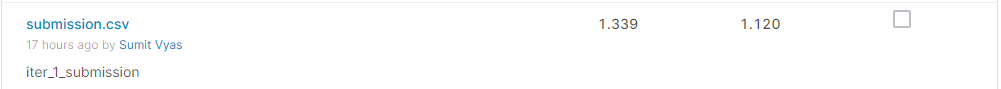

## Iteration 2:

About Experiment:
- Modelling was performed only on meter 0 readings keeping other meter type reading as earlier
- Meter 0 reading was further cleaned by removing all zero readings
- We also filtered additional building readings based on eda

- Results:
    - meter 0 (* 2 models were trained for meter 0 as training samples were large to fit in memory)
        - train rmse: 0.226081
        - test rmse: 0.298898

- Conclusion:
    - rmse score improved compared to previous model on meter 0 reading

In [ ]:
expt = experiment(meter_0_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'month',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt36', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 1 by day with additional preprocessing', n=1449, building_sample=building_sample_1)
expt.run_by_day(name='expt37', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 2 by day with additional preprocessing', n=1449, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's l2: 0.0794623	training's rmse: 0.281891	valid_1's l2: 0.109417	valid_1's rmse: 0.330783
[202]	training's l2: 0.0591791	training's rmse: 0.243268	valid_1's l2: 0.1001	valid_1's rmse: 0.316385
[303]	training's l2: 0.0511125	training's rmse: 0.226081	valid_1's l2: 0.0974928	valid_1's rmse: 0.312238
Early stopping, best iteration is:
[336]	training's l2: 0.0492689	training's rmse: 0.221966	valid_1's l2: 0.0969743	valid_1's rmse: 0.311407
Training until validation scores don't improve for 10 rounds.
[101]	training's l2: 0.072919	training's rmse: 0.270035	valid_1's l2: 0.100242	valid_1's rmse: 0.31661
[202]	training's l2: 0.0558113	training's rmse: 0.236244	valid_1's l2: 0.0909618	valid_1's rmse: 0.301599
Early stopping, best iteration is:
[250]	training's l2: 0.0514101	training's rmse: 0.226738	valid_1's l2: 0.0893403	valid_1's rmse: 0.298898


### Inference

In [ ]:
#create experiment object for inference
expt = experiment(data=[]) #create a dummy object of experiment class
#from get_results method we have access to logs of our experiment conducted
#which can be used either for inference or reproduce results
expt.get_results() 
# from logs we got the model path
model_0_1 = pickle.load(open('model/expt36-20220823-031027.pkl', 'rb'))
model_0_2 = pickle.load(open('model/expt37-20220823-031215.pkl', 'rb'))

#prepare data for inference
final_data_2017 = pickle.load(open('data/final_data/final_data_2017.pkl', 'rb'))
final_data_2018 = pickle.load(open('data/final_data/final_data_2018.pkl', 'rb'))
#split data based on meter type (meter=0)
meter_0_data_2017 = final_data_2017[final_data_2017.meter==0]
meter_0_data_2018 = final_data_2018[final_data_2018.meter==0]
#further split data based on building sample(only applicable for meter 0)
meter_0_1_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_1)]
meter_0_2_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_2)]
meter_0_1_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_1)]
meter_0_2_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_2)]

del final_data_2017, final_data_2018

In [ ]:
#expt.predict(model_object, list_of_data, list_of_feature)
#both path_for_model_object and list_of_feature we can retrieve from expt.get_results method
y_hat_meter_0_1 = expt.predict(model_0_1, [meter_0_1_data_2017, meter_0_1_data_2018], feature=feature)
y_hat_meter_0_2 = expt.predict(model_0_2, [meter_0_2_data_2017, meter_0_2_data_2018], feature=feature)

y_hat = pd.concat([y_hat_meter_0_1, y_hat_meter_0_2])
del y_hat_meter_0_1,y_hat_meter_0_2

last_submission = pd.read_csv('iter_1_submission.csv')

last_submission = last_submission.merge(y_hat, on='row_id', how='left')
last_submission['meter_reading_y'] = last_submission['meter_reading_y'].fillna(last_submission['meter_reading_x'])
last_submission.drop(columns='meter_reading_x', inplace=True)
last_submission = last_submission.rename(columns={'meter_reading_y':'meter_reading'})
assert last_submission.isna().sum().sum() == 0

last_submission.to_csv("iter_2_submission.csv", index=False, float_format="%.4f")

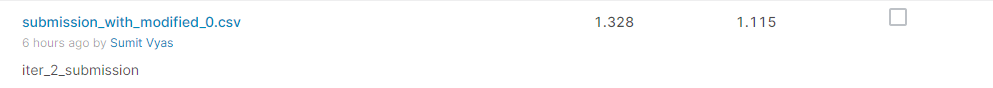

## Iteration 3:

About Experiment:
- Modelling was performed only on meter 1 readings keeping other meter type reading as earlier
- We removed building 778 building readings which was clearly an outlier as concluded in eda

- Results:
    - train rmse: 0.679996
    - test rmse: 0.939853

- Conclusion:
    - rmse score improved slighly compared to previous model on meter 1 reading

In [ ]:
expt = experiment(meter_1_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'month',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt40', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 1 building by day with additional preprocessing', n=1449, building_sample=None)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.846222	training's l2: 0.716091	valid_1's rmse: 0.983802	valid_1's l2: 0.967866
[202]	training's rmse: 0.7407	training's l2: 0.548636	valid_1's rmse: 0.949763	valid_1's l2: 0.90205
[303]	training's rmse: 0.690136	training's l2: 0.476288	valid_1's rmse: 0.941279	valid_1's l2: 0.886007
Early stopping, best iteration is:
[331]	training's rmse: 0.679996	training's l2: 0.462394	valid_1's rmse: 0.939853	valid_1's l2: 0.883323


### Inference

In [ ]:
#create experiment object for inference
expt = experiment(data=[]) #create a dummy object of experiment class
#from get_results method we have access to logs of our experiment conducted
#which can be used either for inference or reproduce results
expt.get_results() 
# from logs we got the model path
model_1 = pickle.load(open('model/expt40-20220823-050308.pkl', 'rb'))

#prepare data for inference
final_data_2017 = pickle.load(open('data/final_data/final_data_2017.pkl', 'rb'))
final_data_2018 = pickle.load(open('data/final_data/final_data_2018.pkl', 'rb'))
#split data based on meter type (meter=1)
meter_1_data_2017 = test_data_2017[test_data_2017.meter==1]
meter_1_data_2018 = test_data_2018[test_data_2018.meter==1]

del final_data_2017, final_data_2018

In [ ]:
#expt.predict(model_object, list_of_data, list_of_feature)
#both path_for_model_object and list_of_feature we can retrieve from expt.get_results method
y_meter_1 = expt.predict(model_1, [meter_1_data_2017, meter_1_data_2018], feature=feature)

y_hat = y_meter_1

last_submission = pd.read_csv('iter_2_submission.csv')

last_submission = last_submission.merge(y_hat, on='row_id', how='left')
last_submission['meter_reading_y'] = last_submission['meter_reading_y'].fillna(last_submission['meter_reading_x'])
last_submission.drop(columns='meter_reading_x', inplace=True)
last_submission = last_submission.rename(columns={'meter_reading_y':'meter_reading'})
assert last_submission.isna().sum().sum() == 0

last_submission.to_csv("iter_3_submission.csv", index=False, float_format="%.4f")

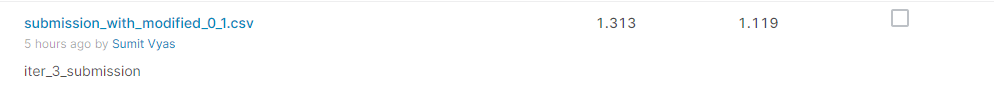

## Iteration 4:

About Experiment:
- We added two new features:
    - building_hour_mean (mean meter reading groupby building, month and hour)
    - meter_hour_mean (mean meter reading groupby meter type, month and hour)
- Performed modelling only on meter 0 readings

- Results:
    - meter 0 (* 2 models were trained for meter 0 as training samples were large to fit in memory)
        - train rmse: 0.199059
        - test rmse: 0.3231

- Conclusion:
    - even though train rmse improved compared to earlier model but test rmse increased
    - clearly model overfitted the train data

In [ ]:
expt = experiment(meter_0_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour', 'building_hour_mean', 'meter_hour_mean']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'month',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt41', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 1 by day with mean reading added', n=1449, building_sample=building_sample_1)
expt.run_by_day(name='expt42', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 2 by day with mean reading added', n=1449, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's l2: 0.0568798	training's rmse: 0.238495	valid_1's l2: 0.116886	valid_1's rmse: 0.341886
[202]	training's l2: 0.0455155	training's rmse: 0.213344	valid_1's l2: 0.113314	valid_1's rmse: 0.336622
Early stopping, best iteration is:
[199]	training's l2: 0.045722	training's rmse: 0.213827	valid_1's l2: 0.113305	valid_1's rmse: 0.336608
Training until validation scores don't improve for 10 rounds.
[101]	training's l2: 0.0511701	training's rmse: 0.226208	valid_1's l2: 0.108163	valid_1's rmse: 0.328882
[202]	training's l2: 0.0424053	training's rmse: 0.205925	valid_1's l2: 0.10477	valid_1's rmse: 0.323681
Early stopping, best iteration is:
[261]	training's l2: 0.0396244	training's rmse: 0.199059	valid_1's l2: 0.104394	valid_1's rmse: 0.3231


### Inference

In [ ]:
#create experiment object for inference
expt = experiment(data=[]) #create a dummy object of experiment class
#from get_results method we have access to logs of our experiment conducted
#which can be used either for inference or reproduce results
expt.get_results() 
# from logs we got the model path
model_0_1 = pickle.load(open('model/expt41-20220823-054637.pkl', 'rb'))
model_0_2 = pickle.load(open('model/expt42-20220823-054853.pkl', 'rb'))

#prepare data for inference
final_data_2017 = pickle.load(open('data/final_data/final_data_2017.pkl', 'rb'))
final_data_2018 = pickle.load(open('data/final_data/final_data_2018.pkl', 'rb'))
#split data based on meter type (meter=0)
meter_0_data_2017 = final_data_2017[final_data_2017.meter==0]
meter_0_data_2018 = final_data_2018[final_data_2018.meter==0]
#further split data based on building sample(only applicable for meter 0)
meter_0_1_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_1)]
meter_0_2_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_2)]
meter_0_1_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_1)]
meter_0_2_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_2)]

del final_data_2017, final_data_2018, meter_0_data_2017, meter_0_data_2018

In [ ]:
#expt.predict(model_object, list_of_data, list_of_feature)
#both path_for_model_object and list_of_feature we can retrieve from expt.get_results method
y_hat_meter_0_1 = expt.predict(model_0_1, [meter_0_1_data_2017, meter_0_1_data_2018], feature=feature)
y_hat_meter_0_2 = expt.predict(model_0_2, [meter_0_2_data_2017, meter_0_2_data_2018], feature=feature)

y_hat = pd.concat([y_hat_meter_0_1, y_hat_meter_0_2])
del y_hat_meter_0_1,y_hat_meter_0_2,y_hat_meter_1

last_submission = pd.read_csv('iter_3_submission.csv')

last_submission = last_submission.merge(y_hat, on='row_id', how='left')
last_submission['meter_reading_y'] = last_submission['meter_reading_y'].fillna(last_submission['meter_reading_x'])
last_submission.drop(columns='meter_reading_x', inplace=True)
last_submission = last_submission.rename(columns={'meter_reading_y':'meter_reading'})
assert last_submission.isna().sum().sum() == 0

last_submission.to_csv("iter_4_submission.csv", index=False, float_format="%.4f")

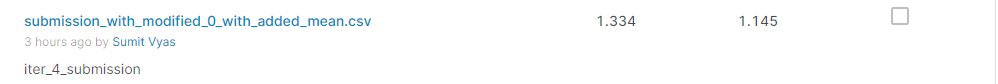

## Iteration 5:

About Experiment:
- We added following new features:
    - hour_mean (groupby building, meter, month, hour)
    - dayofweek_mean (groupby building, month, dayofweek)
    - month_mean (groupby building, meter, month)
    - quarter_mean (groupby building, meter, quarter)
- Also we removed building id feature and check its performance
- Performed modelling only on meter 3 readings excluding building 279, 287

- Results:
    - train rmse: 1.05
    - test rmse: 1.25968

- Conclusion:
    - last_best_rmse on meter 3
        - train rmse: 1.06284
        - test rmse: 1.26033
    - rmse score improved slightly from past model however it didn't performed well unseen test data

In [9]:
meter_3_data = final_data_2016[(final_data_2016.meter==3) & ~(final_data_2016.building_id.isin([279,287]))]

In [ ]:
meter_3_data.dtypes

In [72]:
expt = experiment(meter_3_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour', 
           'quarter_mean' , 'month_mean', 'dayofweek_mean', 'hour_mean']
           
categorical_feature = ['building_id', 'quarter',
                       'site_id', 'primary_use', 'month',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt50', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 3 building by day with mean reading added',
                n=1449, building_sample=None)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[42]	training's l2: 1.10973	training's rmse: 1.05344	valid_1's l2: 1.56598	valid_1's rmse: 1.25139


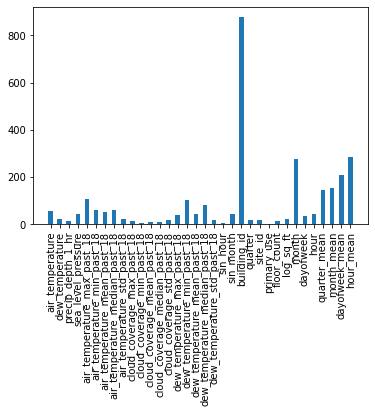

In [73]:
expt.plot_feature_importance(feature=feature)

In [76]:
expt = experiment(meter_3_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour', 
           'quarter_mean' , 'month_mean', 'dayofweek_mean', 'hour_mean']
           
categorical_feature = ['quarter',
                       'site_id', 'primary_use', 'month',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt51', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='building agnostic meter 3 by day with mean reading added',
                n=1449, building_sample=None)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['dayofweek', 'hour', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[67]	training's l2: 1.11455	training's rmse: 1.05572	valid_1's l2: 1.58678	valid_1's rmse: 1.25968


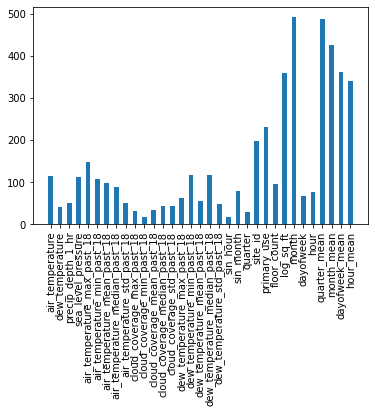

In [77]:
expt.plot_feature_importance(feature=feature)

In [12]:
expt = experiment(meter_3_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour', 
           'quarter_mean' , 'month_mean', 'dayofweek_mean', 'hour_mean']
           
categorical_feature = ['quarter',
                       'site_id', 'primary_use', 'month',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt52', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='building agnostic meter 3 by day with mean reading added',
                n=1449, building_sample=None)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['dayofweek', 'hour', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[55]	training's rmse: 1.0779	training's l2: 1.16187	valid_1's rmse: 1.26252	valid_1's l2: 1.59395


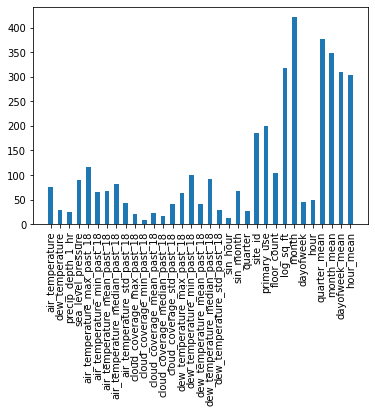

In [13]:
expt.plot_feature_importance(feature=feature)

### Inference:

In [78]:
del final_data_2016, meter_3_data

In [15]:
#create experiment object for inference
expt = experiment(data=[]) #create a dummy object of experiment class
#from get_results method we have access to logs of our experiment conducted
#which can be used either for inference or reproduce results
expt.get_results() 
# from logs we got the model path
model_3 = pickle.load(open('model/expt52-20220825-161611.pkl', 'rb'))
#prepare data for inference
final_data_2017 = pickle.load(open('data/final_data/final_data_2017.pkl', 'rb'))
final_data_2018 = pickle.load(open('data/final_data/final_data_2018.pkl', 'rb'))
#split data based on meter type (meter=3)
meter_3_data_2017 = final_data_2017[(final_data_2017.meter==3) &
                                    ~(final_data_2017.building_id.isin([279, 287]))]
meter_3_data_2018 = final_data_2018[(final_data_2018.meter==3) &
                                    ~(final_data_2018.building_id.isin([279, 287]))]
del final_data_2017, final_data_2018

In [80]:
!unzip '03_submission_with_modified_0_1.zip' -d ''

Archive:  03_submission_with_modified_0_1.zip
  inflating: 03_submission_with_modified_0_1.csv  


In [81]:
#expt.predict(model_object, list_of_data, list_of_feature)
#both path_for_model_object and list_of_feature we can retrieve from expt.get_results method
y_hat = expt.predict(model_3, [meter_3_data_2017, meter_3_data_2018], feature=feature)

last_submission = pd.read_csv('iter_3_submission.csv')

last_submission = last_submission.merge(y_hat, on='row_id', how='left')
last_submission['meter_reading_y'] = last_submission['meter_reading_y'].fillna(last_submission['meter_reading_x'])
last_submission.drop(columns='meter_reading_x', inplace=True)
last_submission = last_submission.rename(columns={'meter_reading_y':'meter_reading'})
assert last_submission.isna().sum().sum() == 0

last_submission.to_csv("iter_5_submission.csv", index=False, float_format="%.4f")

In [16]:
#expt.predict(model_object, list_of_data, list_of_feature)
#both path_for_model_object and list_of_feature we can retrieve from expt.get_results method
y_hat = expt.predict(model_3, [meter_3_data_2017, meter_3_data_2018], feature=feature)

last_submission = pd.read_csv('iter_01_submission.csv')

last_submission = last_submission.merge(y_hat, on='row_id', how='left')
last_submission['meter_reading_y'] = last_submission['meter_reading_y'].fillna(last_submission['meter_reading_x'])
last_submission.drop(columns='meter_reading_x', inplace=True)
last_submission = last_submission.rename(columns={'meter_reading_y':'meter_reading'})
assert last_submission.isna().sum().sum() == 0

last_submission.to_csv("iter_06_submission.csv", index=False, float_format="%.4f")

In [18]:
!zip 'iter_06_submission.csv.zip' 'iter_06_submission.csv'

  adding: iter_06_submission.csv (deflated 62%)


In [86]:
y_hat.meter_reading.max()

13.661275053724452

In [87]:
!unzip 'iter_01_submission.zip' -d ''

Archive:  iter_01_submission.zip
  inflating: iter_01_submission.csv  


In [88]:
last_submission = pd.read_csv('iter_01_submission.csv')

In [91]:
last_submission.head()

,row_id,meter_reading
0,0,185.8298
1,1,83.8790
2,2,9.0792
3,3,246.2508
4,4,1365.6563


In [90]:
df = y_hat.merge(last_submission, on=['row_id'], how='left')
df.head()

,row_id,meter_reading_x,meter_reading_y
0,2260082,1.057304,1.6972
1,2260086,1.411150,2.3870
2,2260090,2.263401,18.6473
3,2260092,2.758734,47.2893
4,2260094,3.882326,224.0385


In [96]:
df.head()

,row_id,meter_reading_x,meter_reading_y
0,2260082,1.057304,1.6972
1,2260086,1.411150,2.3870
2,2260090,2.263401,18.6473
3,2260092,2.758734,47.2893
4,2260094,3.882326,224.0385


In [95]:
meter_3_data_2017.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,log_sq_ft,...,dayofweek,hour,quarter,sin_hour,sin_month,sin_wind_direction,quarter_mean,month_mean,dayofweek_mean,hour_mean
1130042,2260082,106,3,2017-01-01,1,1,5374,0,5,8.585938,...,6,0,1,-0.258789,0.382568,-0.939453,2.467732,2.457022,1.868141,1.756202
1130046,2260086,109,3,2017-01-01,1,1,56995,54,7,10.953125,...,6,0,1,-0.258789,0.382568,-0.939453,3.742438,3.759192,3.225520,2.871680
1130050,2260090,112,3,2017-01-01,1,1,32206,0,7,10.382812,...,6,0,1,-0.258789,0.382568,-0.939453,4.967815,4.914694,4.591269,4.187476
1130052,2260092,113,3,2017-01-01,1,1,100481,59,10,11.515625,...,6,0,1,-0.258789,0.382568,-0.939453,4.134656,4.307054,4.306091,4.294684
1130054,2260094,114,3,2017-01-01,1,1,139683,59,14,11.843750,...,6,0,1,-0.258789,0.382568,-0.939453,5.762587,5.805281,5.787984,5.683972
